In [1]:
# Импорт необходимых библиотек
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Это позволяет автоматически распечатывать элементы без необходимости использовать 'print'.
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Импорт фреймворка PySpark
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

spark = SparkSession.builder.master("local[*]").getOrCreate()


In [3]:
# Создание схемы
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType, BooleanType, FloatType
schema = StructType(fields=[
    StructField("legId", StringType ()), 
    StructField("searchDate", DateType()),
    StructField("flightDate", DateType()),
    StructField("startingAirport", StringType()),
    StructField("destinationAirport", StringType()),
    StructField("fareBasisCode", StringType()),
    StructField("travelDuration", StringType()),
    StructField("elapsedDays", IntegerType()),
    StructField("isBasicEconomy", BooleanType()),
    StructField("isRefundable", BooleanType()),
    StructField("isNonStop", BooleanType()),
    StructField("baseFare", FloatType()),
    StructField("totalFare", FloatType()),
    StructField("seatsRemaining", IntegerType()),
    StructField("totalTravelDistance", FloatType()),
    StructField("segmentsDepartureTimeEpochSeconds", StringType()),
    StructField("segmentsDepartureTimeRaw", StringType()),
    StructField("segmentsArrivalTimeEpochSeconds", StringType()),
    StructField("segmentsArrivalTimeRaw", StringType()),
    StructField("segmentsArrivalAirportCode", StringType()),
    StructField("segmentsDepartureAirportCode", StringType()),
    StructField("segmentsAirlineName", StringType()),
    StructField("segmentsAirlineCode", StringType()),
    StructField("segmentsEquipmentDescription", StringType()),
    StructField("segmentsDurationInSeconds", StringType()),
    StructField("segmentsDistance", StringType()),
    StructField("segmentsCabinCode", StringType()),

])

In [4]:
# Укажем директорию к файлу с данными и инициалализируем spark
filename_data = 'data/itineraries.csv'
# Загрузка датасета в датафрейм, 
df = spark.read.csv(filename_data, header=True, schema=schema, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# I. Разведочный анализ данных с помощью PySpark <a class="anchor" id="2"></a>


## Схема, столбцы и типы данных набора данных:
   *В наборе данных столбцы состоят из строковых, числовых, булевых типов данных и дата.

In [5]:
'Data overview'
df.printSchema()
'Columns overview'
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

'Data overview'

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: float (nullable = true)
 |-- totalFare: float (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: float (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: strin

'Columns overview'

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


In [6]:
# Создаим выборку из 100 строк
data = df.sample(True, 0.000001, 42)

In [7]:
data.describe().toPandas()

,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
1,mean,None,None,None,None,None,0.15476190476190477,286.1994044184685,332.32178837912426,6.928571428571429,...,1.658749420909091E9,None,None,None,None,None,None,11473.636363636364,1190.1363636363637,None
2,stddev,None,None,None,None,None,0.3638498173911941,196.61993831775678,211.7396950772026,2.487490215689248,...,4668149.8158986,None,None,None,None,None,None,6060.747671505746,878.0063615918002,None
3,min,01cd93e01c1aa9b0f150ddceea4be3d7,ATL,ATL,BA0OA0MQ,PT10H36M,0,1.01,46.59,0,...,1650755700||1650771240,2022-04-23T16:15:00.000-07:00||2022-04-23T20:3...,ATL,ATL,Alaska Airlines,AA,AIRBUS INDUSTRIE A320 SHARKLETS||AIRBUS INDUST...,10200||6780,1104,coach
4,max,ff346a8c17b59b2535c11fb7d6b5ef2c,SFO,SFO,ZI7AUEL1,PT9H57M,1,1553.49,1703.7,10,...,1668088140,2022-11-10T08:49:00.000-05:00,TPA||MIA,SFO||PHX||LAS,United||United||United,UA||UA||UA,||Embraer 175 (Enhanced Winglets),9900||11580,None||None,coach||coach||coach


In [8]:
data.limit(4).toPandas().transpose()

,0,1,2,3
legId,207edf4a99ed71c2011c516a30661915,9779b11405db2556b86d15c3aa220607,94593cf26176dfc8bd5b7d3d5142fc63,5a0930f8d09d584c19e116ebc65dc695
searchDate,2022-04-18,2022-04-19,2022-04-26,2022-04-26
flightDate,2022-04-23,2022-05-03,2022-04-27,2022-05-16
startingAirport,DEN,ORD,BOS,CLT
destinationAirport,LAX,DFW,EWR,LAX
fareBasisCode,LH0OAJMN,GUAIZNN1,Z0BZZNN3,BA0OA0MQ
travelDuration,PT7H2M,PT2H31M,PT11H51M,PT6H49M
elapsedDays,0,0,0,0
isBasicEconomy,False,False,False,False
isRefundable,False,False,False,False


## Обнаружение отсутствующих значений  <a class="anchor" id="3"></a>


После того как мы увидели столбцы, первое, что мы должны проверить, нет ли в наборе данных пропущенных значений.

In [9]:
from pyspark.sql.functions import isnull, when, count, col
nacounts = data.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()
nacounts.transpose()

,0
legId,0
searchDate,0
flightDate,0
startingAirport,0
destinationAirport,0
fareBasisCode,0
travelDuration,0
elapsedDays,0
isBasicEconomy,0
isRefundable,0


In [10]:
# Т.к. в нашей выборке мало строк с пропущенными значениями, просто удалим их
data = data.dropna()


In [11]:
numeric_dt =  ['totalTravelDistance', 'seatsRemaining', 'totalFare', 'baseFare', 'elapsedDays']

for el in numeric_dt:
    q1 = data.select(el).toPandas().quantile(0.25)
    q3 = data.select(el).toPandas().quantile(0.75)
    iqr = q3-q1
    lower_bound = (q1 - 1.5 * iqr)[0]
    upper_bound = (q3 + 1.5 * iqr)[0]
    data = data.filter( (col(el) >= lower_bound) & (col(el) <= upper_bound) )
    print(f'el:{el}\nlower_bound:{lower_bound}\nupper_bound{upper_bound}')


el:totalTravelDistance
lower_bound:-1377.25
upper_bound4562.75
el:seatsRemaining
lower_bound:4.0
upper_bound12.0
el:totalFare
lower_bound:-102.58749389648438
upper_bound762.9125061035156
el:baseFare
lower_bound:-113.0050048828125
upper_bound679.5150146484375
el:elapsedDays
lower_bound:0.0
upper_bound0.0


## Статистика по числовы данным

In [12]:
data.summary().toPandas().set_index('summary').transpose().dropna()[2:6]

summary,count,mean,stddev,min,25%,50%,75%,max
totalFare,62,308.85129411758913,147.5643828261338,73.6,203.6,264.01,422.6,667.1
seatsRemaining,62,7.67741935483871,1.1703186276014976,4,7,7,9,10
totalTravelDistance,62,1523.774193548387,850.9107833905518,185.0,799.0,1329.0,2332.0,3670.0
segmentsDepartureTimeEpochSeconds,62,1.65809592E9,4538698.23989214,1650745920||1650762600,1.65451068E9,1.6574523E9,1.65978948E9,1668081600


## Графический анализ по данным

In [13]:
startingAirport = data.groupBy('startingAirport').count().toPandas() 


In [14]:
startingAirport['percentage'] = startingAirport['count'] \
    / sum(startingAirport['count']) * 100
startingAirport_stat = startingAirport.sort_values('count', ascending=False).head(6)
startingAirport_stat

,startingAirport,count,percentage
2,BOS,8,12.903226
7,MIA,6,9.677419
10,LGA,6,9.677419
5,DTW,5,8.064516
6,SFO,5,8.064516
9,DFW,5,8.064516


/tmp/ipykernel_78112/2166434716.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(startingAirport_stat['startingAirport']


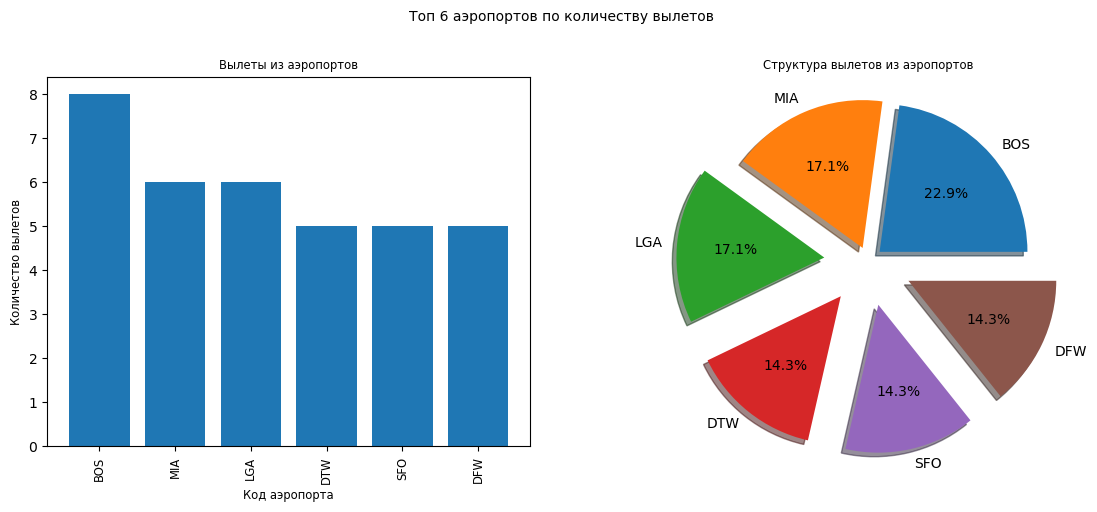

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=startingAirport_stat['startingAirport']
                   , height=startingAirport_stat['count'])
title0 = axs[0].set_title('Вылеты из аэропортов', fontsize='small')
xlabel0 = axs[0].set_xlabel('Код аэропорта', fontsize='small')
ylabel0 = axs[0].set_ylabel('Количество вылетов', fontsize='small')
xsticks_label = axs[0].set_xticklabels(startingAirport_stat['startingAirport']
                                       , rotation='vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Структура вылетов из аэропортов', fontsize = 'small')
plot1 = axs[1].pie(
    x=startingAirport_stat['percentage']
    , labels=startingAirport_stat['startingAirport']
    , autopct='%1.1f%%', shadow=True, explode=explode, radius=1
)

text = fig.text(0.5, 1.02, 'Топ 6 аэропортов по количеству вылетов'
                , ha='center', va='top', transform=fig.transFigure)

In [16]:
destinationAirport = data.groupBy('destinationAirport').count().toPandas() 

In [17]:
destinationAirport['percentage'] = destinationAirport['count'] \
    / sum(destinationAirport['count']) * 100
destinationAirport_stat = destinationAirport.sort_values('count', ascending=False).head(6)
destinationAirport_stat

,destinationAirport,count,percentage
0,LAX,9,14.516129
3,BOS,8,12.903226
8,ATL,7,11.290323
1,DFW,4,6.451613
2,EWR,4,6.451613
4,ORD,4,6.451613


/tmp/ipykernel_78112/399932134.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(destinationAirport_stat['destinationAirport']


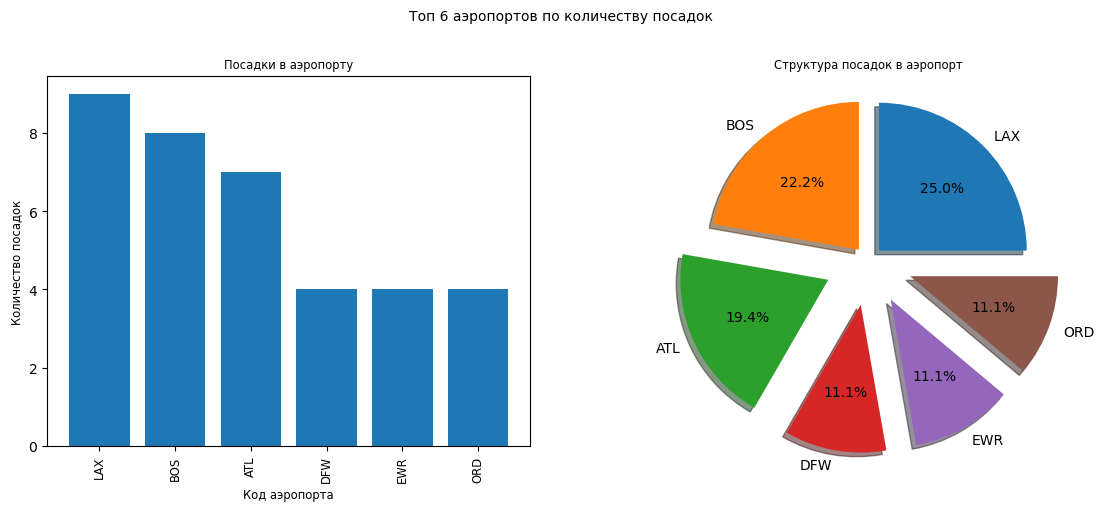

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=destinationAirport_stat['destinationAirport']
                   , height=destinationAirport_stat['count'])
title0 = axs[0].set_title('Посадки в аэропорту', fontsize='small')
xlabel0 = axs[0].set_xlabel('Код аэропорта', fontsize='small')
ylabel0 = axs[0].set_ylabel('Количество посадок', fontsize='small')
xsticks_label = axs[0].set_xticklabels(destinationAirport_stat['destinationAirport']
                                       , rotation='vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Структура посадок в аэропорт', fontsize = 'small')
plot1 = axs[1].pie(
    x=destinationAirport_stat['percentage']
    , labels=destinationAirport_stat['destinationAirport']
    , autopct='%1.1f%%', shadow=True, explode=explode, radius=1
)

text = fig.text(0.5, 1.02, 'Топ 6 аэропортов по количеству посадок'
                , ha='center', va='top', transform=fig.transFigure)

In [19]:
data_analytic = data.toPandas()

<Axes: >

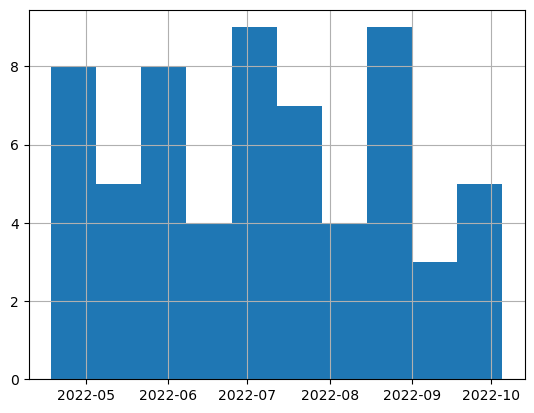

In [20]:
data_analytic.searchDate.hist()

<Axes: >

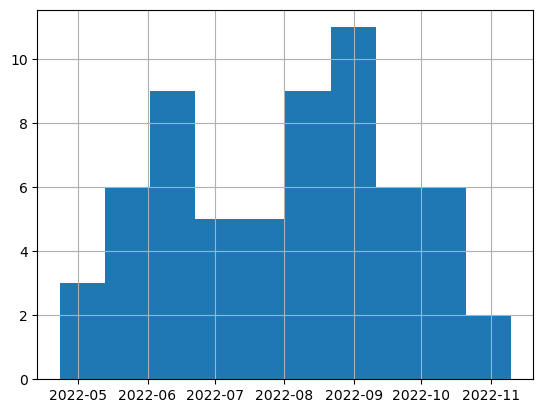

In [21]:
data_analytic.flightDate.hist()

array([[<Axes: title={'center': 'baseFare'}>,
        <Axes: title={'center': 'totalFare'}>],
       [<Axes: title={'center': 'seatsRemaining'}>,
        <Axes: title={'center': 'totalTravelDistance'}>]], dtype=object)

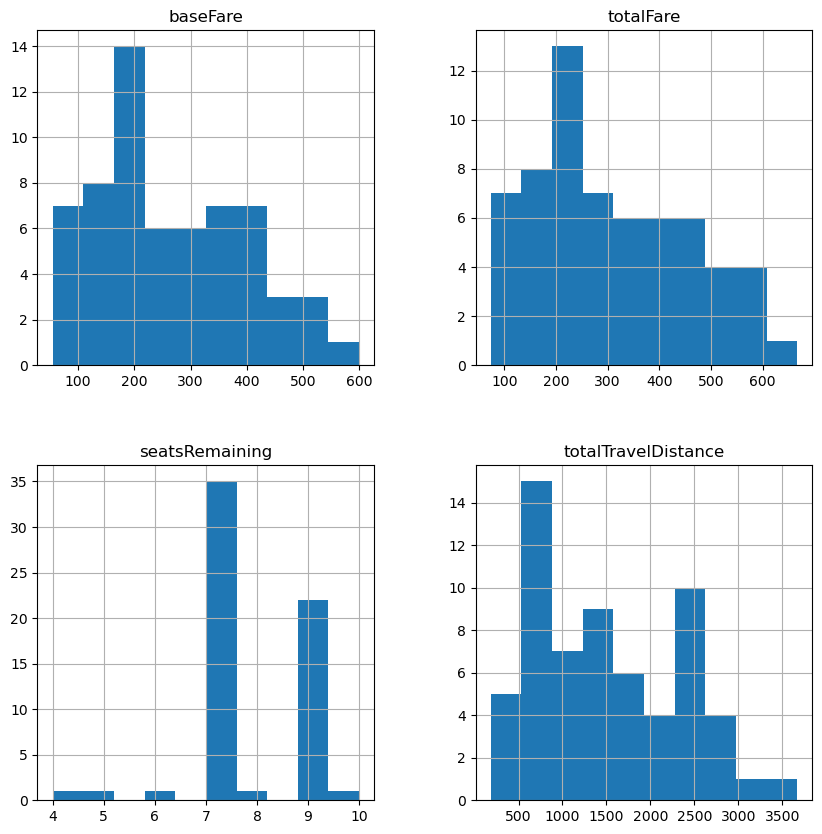

In [22]:
data_analytic[['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']].hist(figsize=(10,10))

11

62

([<matplotlib.patches.Wedge at 0x7f45d803ac90>,
 [Text(0.9335086929096249, 0.5818603958529602, 'Экономичный билет'),
  Text(-0.933508720148475, -0.5818603521522637, 'Не экономичный')],
 [Text(0.5091865597688863, 0.31737839773797827, '17.7%'),
  Text(-0.5091865746264409, -0.3173783739012347, '82.3%')])

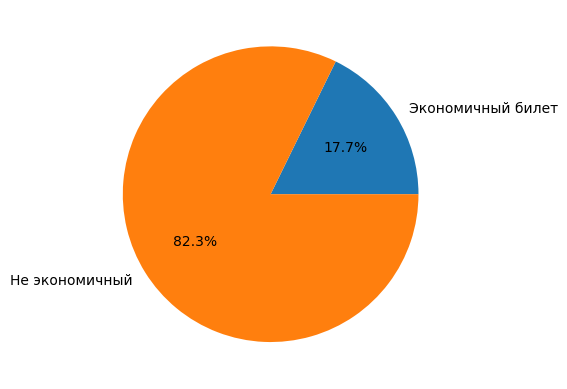

In [23]:
sum(data_analytic.isBasicEconomy)
data_analytic.isBasicEconomy.count()
# Круговая диаграмма, секторы которой будут упорядочены и расположены против часовой стрелки:
labels = 'Экономичный билет', 'Не экономичный'
sizes = [(sum(data_analytic.isBasicEconomy)/data_analytic.isBasicEconomy.count()), 1-(sum(data_analytic.isBasicEconomy)/data_analytic.isBasicEconomy.count())]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

0

62

([<matplotlib.patches.Wedge at 0x7f45d8089150>,
 [Text(1.1, 0.0, 'Возвратный билет'),
  Text(-1.1, 1.3471114790620887e-16, 'Не возвратный билет')],
 [Text(0.6, 0.0, '0.0%'), Text(-0.6, 7.347880794884119e-17, '100.0%')])

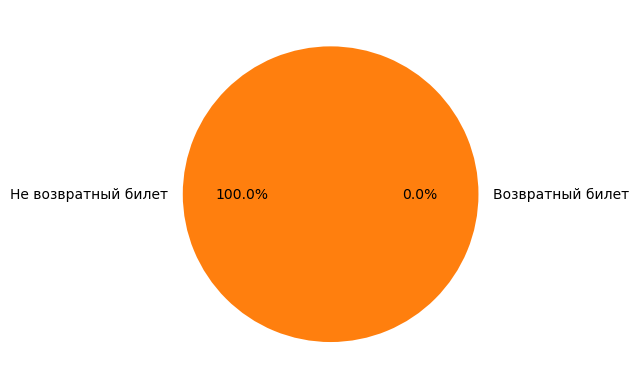

In [24]:

sum(data_analytic.isRefundable)
data_analytic.isRefundable.count()
# Круговая диаграмма, секторы которой будут упорядочены и расположены против часовой стрелки:
labels = 'Возвратный билет', 'Не возвратный билет'
sizes = [(sum(data_analytic.isRefundable)/data_analytic.isRefundable.count()), 1-(sum(data_analytic.isRefundable)/data_analytic.isRefundable.count())]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

19

62

([<matplotlib.patches.Wedge at 0x7f45d8056fd0>,
 [Text(0.6283950202436337, 0.9028397967153438, 'Беспосадочный рейс'),
  Text(-0.6283950202436337, -0.9028397967153439, 'Посадочный рейс')],
 [Text(0.3427609201328911, 0.492458070935642, '30.6%'),
  Text(-0.3427609201328911, -0.49245807093564203, '69.4%')])

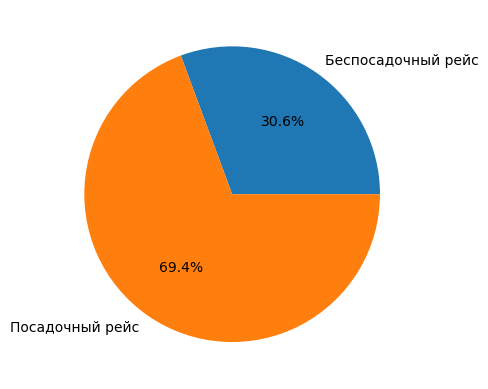

In [25]:
sum(data_analytic.isNonStop)
data_analytic.isNonStop.count()
# Круговая диаграмма, секторы которой будут упорядочены и расположены против часовой стрелки:
labels = 'Беспосадочный рейс', 'Посадочный рейс'
sizes = [(sum(data_analytic.isNonStop)/data_analytic.isNonStop.count()), 1-(sum(data_analytic.isNonStop)/data_analytic.isNonStop.count())]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

In [26]:
corr = data_analytic[['totalTravelDistance', 'seatsRemaining', 'totalFare', 'baseFare']].corr()
corr.style.background_gradient()

,totalTravelDistance,seatsRemaining,totalFare,baseFare
totalTravelDistance,1.000000,0.195296,0.425709,0.416165
seatsRemaining,0.195296,1.000000,0.150406,0.148237
totalFare,0.425709,0.150406,1.000000,0.999480
baseFare,0.416165,0.148237,0.999480,1.000000


# II. Машинное обучение на больших данных  <a class="anchor" id="3"></a>


In [28]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [29]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [151]:
dataml = data.select(((col("isBasicEconomy")).cast("Int").alias("isBasicEconomyInt")), ((col("isNonStop")).cast("Int").alias("isNonStopInt")), 'totalFare', 'totalTravelDistance', 'seatsRemaining')

In [152]:
dataml.show(5)

+-----------------+------------+---------+-------------------+--------------+
|isBasicEconomyInt|isNonStopInt|totalFare|totalTravelDistance|seatsRemaining|
+-----------------+------------+---------+-------------------+--------------+
|                0|           0|   431.98|             1818.0|             7|
|                0|           1|    172.6|              799.0|             7|
|                0|           0|   249.21|             1582.0|             7|
|                0|           0|    667.1|             2171.0|             9|
|                0|           0|   349.21|             1392.0|             7|
+-----------------+------------+---------+-------------------+--------------+
only showing top 5 rows



In [153]:
dataml.printSchema()

root
 |-- isBasicEconomyInt: integer (nullable = true)
 |-- isNonStopInt: integer (nullable = true)
 |-- totalFare: float (nullable = true)
 |-- totalTravelDistance: float (nullable = true)
 |-- seatsRemaining: integer (nullable = true)



## Построение регрессии на основе Random forest regression

In [154]:
dff = dataml

In [155]:
# Объединяем все признаки в один столбец 'features'
feature_columns = dff.columns
feature_columns.remove("totalFare")  # Удаляем целевую переменную из списка признаков
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
dff = assembler.transform(dff)



In [156]:
# Разделяем данные на обучающий и тестовый наборы
train_data, test_data = dff.randomSplit([0.8, 0.2], seed=42)



In [157]:
# Создаем модель случайного леса для регрессии
rf = RandomForestRegressor(featuresCol="features", labelCol="totalFare")



In [158]:
# Обучаем модель на обучающем наборе
rf_model = rf.fit(train_data)



In [159]:
# Получаем прогнозы на тестовом наборе
predictions = rf_model.transform(test_data)



In [160]:
# Оцениваем качество модели
evaluator = RegressionEvaluator(labelCol="totalFare", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)



Root Mean Squared Error (RMSE) on test data = 117.83629206128938


In [161]:
# Отображаем важность признаков
print("Feature Importances:", rf_model.featureImportances)

Feature Importances: (4,[0,1,2,3],[0.2310696413820006,0.04968418799869869,0.6144445465466536,0.10480162407264712])


In [165]:
# Определяем сетку гиперпараметров для перебора
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()



In [166]:
# Создаем оценщик для оценки качества модели (Root Mean Squared Error)
evaluator = RegressionEvaluator(labelCol="totalFare", predictionCol="prediction", metricName="rmse")



In [167]:
# Создаем кросс-валидатор
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)



In [168]:
# Обучаем модель с кросс-валидацией
cv_model = crossval.fit(train_data)



In [169]:
# Получаем лучшую модель
best_model = cv_model.bestModel



In [170]:
# Получаем прогнозы на тестовом наборе
predictions = best_model.transform(test_data)



In [171]:
# Оцениваем качество лучшей модели на тестовом наборе
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)



Root Mean Squared Error (RMSE) on test data = 124.53822379494504


In [172]:
# Отображаем важность признаков
print("Feature Importances:", best_model.featureImportances)

Feature Importances: (4,[0,1,2,3],[0.22434428111200194,0.04240846503510581,0.6114517634010642,0.12179549045182814])


## Классификация на основе Logistic regression

In [173]:
dfc = dataml

In [174]:
# Объединяем все признаки в один столбец 'features'
feature_columns = dfc.columns
feature_columns.remove("isBasicEconomyInt")  # Удаляем целевую переменную из списка признаков
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
dfc = assembler.transform(dfc)



In [181]:
# Разделяем данные на обучающий и тестовый наборы
train_data, test_data = dfc.randomSplit([0.8, 0.2], seed=42)



In [182]:
# Создаем модель логистической регрессии для классификации
lr = LogisticRegression(featuresCol="features", labelCol="isBasicEconomyInt")



In [183]:
# Определяем сетку гиперпараметров для перебора
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()



In [184]:
# Создаем оценщик для оценки качества модели (бинарная классификация)
evaluator = BinaryClassificationEvaluator(labelCol="isBasicEconomyInt", metricName="areaUnderROC")



In [185]:
# Создаем кросс-валидатор
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)



In [186]:
# Обучаем модель с кросс-валидацией
cv_model = crossval.fit(train_data)



In [187]:
# Получаем лучшую модель
best_model = cv_model.bestModel



In [188]:
# Получаем прогнозы на тестовом наборе
predictions = best_model.transform(test_data)



In [189]:
# Оцениваем качество лучшей модели на тестовом наборе
auc = evaluator.evaluate(predictions)
print("Area Under ROC (AUC) on test data =", auc)

Area Under ROC (AUC) on test data = 0.9743589743589743


In [193]:
predictions.select(['features', 'isBasicEconomyInt', 'prediction']).show(100, truncate=False)

+-----------------------------------+-----------------+----------+
|features                           |isBasicEconomyInt|prediction|
+-----------------------------------+-----------------+----------+
|[0.0,431.9800109863281,1818.0,7.0] |0                |0.0       |
|[0.0,249.2100067138672,1582.0,7.0] |0                |0.0       |
|[1.0,320.6000061035156,862.0,7.0]  |0                |0.0       |
|[1.0,478.6000061035156,447.0,8.0]  |0                |0.0       |
|[0.0,440.19000244140625,1242.0,7.0]|0                |0.0       |
|[0.0,399.1000061035156,776.0,5.0]  |0                |0.0       |
|[0.0,264.010009765625,947.0,4.0]   |0                |0.0       |
|[0.0,606.1099853515625,2561.0,9.0] |0                |0.0       |
|[0.0,171.60000610351562,1213.0,7.0]|0                |0.0       |
|[0.0,438.6000061035156,2557.0,9.0] |0                |0.0       |
|[1.0,358.6000061035156,2566.0,7.0] |0                |0.0       |
|[0.0,177.61000061035156,2611.0,9.0]|1                |1.0    

In [192]:
# Recalculate confusion matrix
tp2 = float(predictions.filter("prediction == 1.0 AND isBasicEconomyInt == 1").count())
fp2 = float(predictions.filter("prediction == 1.0 AND isBasicEconomyInt == 0").count())
tn2 = float(predictions.filter("prediction == 0.0 AND isBasicEconomyInt == 0").count())
fn2 = float(predictions.filter("prediction == 0.0 AND isBasicEconomyInt == 1").count())
pr2 = tp2 / (tp2 + fp2)
re2 = tp2 / (tp2 + fn2)
metrics2 = spark.createDataFrame([
 ("TP", tp2),
 ("FP", fp2),
 ("TN", tn2),
 ("FN", fn2),
 ("Precision", pr2),
 ("Recall", re2),
 ("F1", 2*pr2*re2/(re2+pr2))],["metric", "value"])
metrics2.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|               1.0|
|       FP|               0.0|
|       TN|              13.0|
|       FN|               2.0|
|Precision|               1.0|
|   Recall|0.3333333333333333|
|       F1|               0.5|
+---------+------------------+

